In [1]:
#given a dataset for H(z), z, err(H), we do an MCMC analysis and find corner plots for the data

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
import corner
from IPython.display import display, Math
import pandas as pd

In [2]:
#------ EQUATIONS FOR OUR THEORY ------

# NOTE: for now only for flat universe (need to change D_A(z))
# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    h , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    Omega_r = (2.47e-5*h**-2)*1.6949484   # last factor due to neutrinos
    
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    h , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    Omega_r = (2.47e-5*h**-2)*1.6949484   # last factor due to neutrinos
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    if alpha_tilde == 0:
        return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        return np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2*alpha_tilde*Omega_k*(1+z)**2))/(2 * alpha_tilde))
    
# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Shift parameter
def R(cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.sqrt(Omg_m)*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]

# Acoustic scale
def l_A(cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.pi*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]/\
           scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), 0 , 1/(1+z_CMB(Omg_b,Omg_m,h)))[0]

In [3]:
def log_likelihood(theta, y, C_CMB):
    wb, wm, h = theta
    Omg_b = wb/h**2
    Omg_m = wm/h**2
    Omg_c = Omg_m - Omg_b
    cosmo = [h , Omg_b , Omg_c , 0 , 0]
    model = [R(cosmo) , l_A(cosmo) , wb]
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(C_CMB)),np.transpose(y-model))

In [4]:
def log_prior(theta):
    wb, wm, h  = theta
    # Limits due to paramterized form (https://arxiv.org/pdf/astro-ph/9510117.pdf, appendix E1/E2)
    # based on theory calculations that include ionization history
    if 0.0025 < wb < 0.25 and 0.0 < h < 1 and 0.025 < wm < 0.64:
        return 0.0
    return -np.inf

In [5]:
def log_probability(theta, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr)

In [6]:
#get the data

# Choose the seed parameters.
wb_est = 0.2
wm_est = 0.5
h_est = 0.9

# Our data: y = [R , l_a , Omgb_hsquared] at z_CMB, and our Covariance matrix
C_CMB = 1e-8*np.array([[1598.9554 , 17112.007 , -36.311179],
              [17112.007 , 811208.45 , -494.79813],
              [-36.311179 , -494.79813 , 2.1242182]])

y = np.array([1.74963, 301.80845, 0.02237])


In [7]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [wb_est , wm_est , h_est] + 1e-3 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=( y, C_CMB)
)
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [01:26<00:00, 11.56it/s]


(2650, 3)


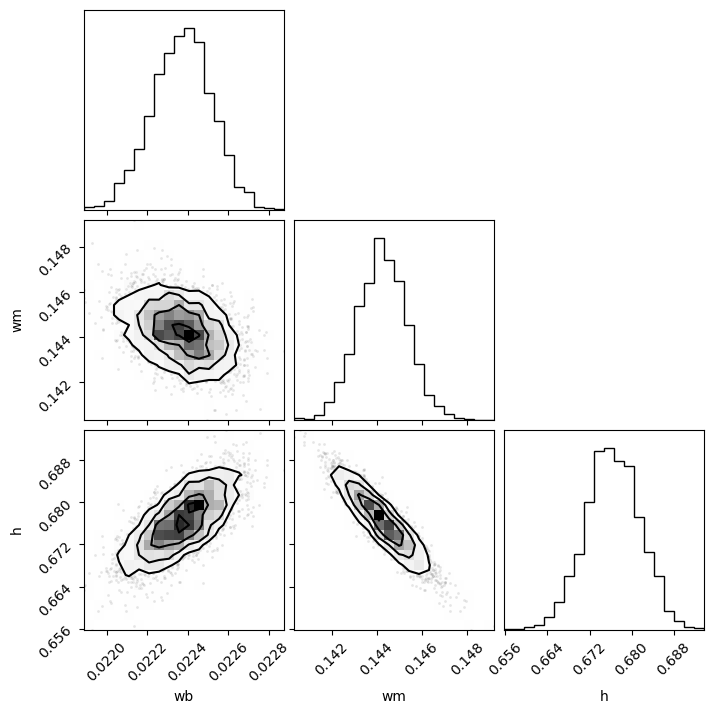

In [8]:
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
labels = ["wb", "wm" , "h"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[wb_est, wm_est, h_est]
);

Text(0, 0.5, 'h')

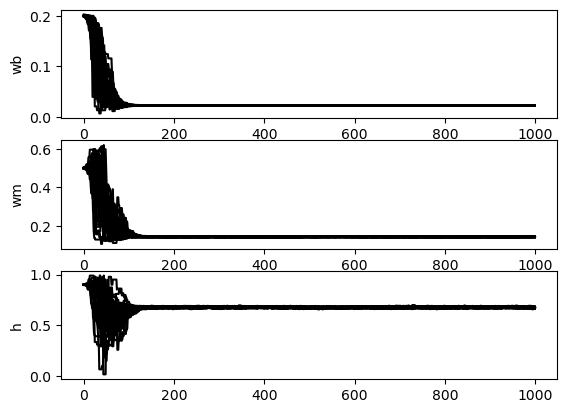

In [9]:
samples_chain = sampler.chain

fig, ax = plt.subplots(3)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")

ax[0].set_ylabel("wb")
ax[1].set_ylabel("wm")
ax[2].set_ylabel("h")

In [10]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>